# Tutorial: Deep Learning using Convolutional Neural Networks
# Example: Car Recognition

This tutorial shows how Convolutional Neural Networks are used to recognize cars on images vs. images with no cars on them (binary classification).

The data set used is the [UIUC Image Database for Car Detection](http://cogcomp.cs.illinois.edu/Data/Car/) containing:
* 1050 training images (550 car and 500 non-car images)
* 170 test images, containing 200 cars at roughly the same scale as in the training images 
(we do not use the multi-scale test images, containing 139 cars at various scales, here)

This tutorial contains:
* Image Loading and Preprocessing
* Standardization of Data
* Fully Connected Neural Networks
* Convolutional Neural Networks
* Batch Normalization
* ReLU Activation
* Dropout
* Data Augmentation
* Plotting the Training Curve

You can execute the following code blocks by pressing SHIFT+Enter consecutively.

In [1]:
import os

# if you want to use the GPU
#device = 'gpu'
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=' + device + ',floatX=float32'

import argparse
import csv
import datetime
import glob
import math
import numpy as np
import sys
import time

from PIL import Image
from sklearn.metrics import accuracy_score

#import keras
from keras.backend import floatx  # abstract default float type for Keras (e.g. float32)
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization

np.random.seed(1) # we initialize a random seed here to make the experiments repeatable with same results

Using TensorFlow backend.


## Load the Images from Training Set

Set the DATA_PATH please:

In [2]:
# if you use the iDSDL Lab machine
DATA_PATH = '/home/ffg/idsdlmteacher1/Code/DeepLearningTutorial_2019/data'
# if you downloaded the dataset into the tutorial folder (otherwise adjust the DATA_PATH please)
# DATA_PATH = '.'

In [3]:
path = os.path.join(DATA_PATH, 'CarData/TrainImages')
files = glob.glob(os.path.join(path, '*.pgm'))
print("Found %d files" % len(files))

Found 1050 files


In [4]:
images = []
image_names = []

for filename in files:
    image_names.append(os.path.basename(filename))
    with Image.open(filename) as img:
        images.append(np.array(img)) # we convert the images to a Numpy array and store them in a list

In [5]:
len(images)

1050

pos-279.pgm


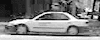

In [6]:
# show a selected image to check
i=700
print(image_names[i])
Image.fromarray(images[i])

In [7]:
type(images[i])

numpy.ndarray

In [8]:
images[i].shape   # height x width   (Numpy ordering)

(40, 100)

Note: Color RGB images have an additional dimension of depth 3, e.g. (40, 100, 3)

## Make 1 big array of list of images

In [9]:
# a list of many 40x100 images is made into 1 big array
# as data type we use "floatx()" from Keras which is imported above (for GPU it is most often float32)
img_array = np.array(images, dtype=floatx())
img_array.shape

(1050, 40, 100)

## Create the Groundtruth based on filenames:

In this data set, images with cars start with "pos-" and images with no cars start with "neg-". We create a numeric list here, containing 1 for car images and 0 for non-car images.

In [10]:
classes = []
for name in image_names:
    if name.startswith('neg'):
        classes.append(0)
    else:
        classes.append(1)

In [11]:
# look at the first 25 classes
classes[0:25]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [12]:
# look classes 490 to 510
classes[490:510]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [13]:
print("Groundtruth Statistics:")

for c in set(classes):
    print("Class {}: {} instances".format(c, classes.count(c)))

Groundtruth Statistics:
Class 0: 500 instances
Class 1: 550 instances


In [14]:
baseline = 550 * 1.0 / len(classes)
print("baseline = %.3f" % baseline)

baseline = 0.524


The baseline is 52.4%, i.e. a 'dumb' classifier can assign all predictions to the majority class achieving this accurcay. We aim at building a classifier that performs better than that.

## Standardization

<b>Always standardize</b> the data before feeding it into the Neural Network!

Here we use <b>Zero-mean Unit-variance standardization</b> which means we deduct the mean and divide by the standard deviation.

(Note: Here, we do this "flat", i.e. one mean and std.dev. for the whole image is computed over all pixels (not per pixel); in RGB images, standardization can be done e.g. for each colour channel individually; in other/non-image data sets, attribute-wise standardization should be applied).

In [15]:
img_array.min(), img_array.max()

(0.0, 255.0)

In [16]:
# compute mean and standard deviation
mean = img_array.mean()
stddev = img_array.std()
mean, stddev

(129.58243, 74.27672)

In [17]:
# apply zero mean unit variance standardization on all pixels of all images
img_array = (img_array - mean) / stddev
img_array.mean(), img_array.std()

(5.298578e-07, 0.99999976)

In [18]:
#check the new min, mean and max
img_array.min(), img_array.mean(), img_array.max()

(-1.7445902, 5.298578e-07, 1.6885179)

# Creating Neural Network Models in Keras

## Fully Connected Networks

For a fully connected neural network, the x and y axis of an image do not play a role at all. All pixels are considered as a completely individual input to the neural network. Therefore the 2D image arrays have to be flattened to a vector.

In [19]:
#  flatten images to vectors
images_flat = img_array.reshape(img_array.shape[0],-1)
images_flat.shape

(1050, 4000)

In [20]:
# find out input shape for NN, which is just a long vector (40x100 = 4000)
input_shape = images_flat.shape[1]
input_shape

4000

### Creating a Model

In Keras, one can choose between a **Sequential model** and a **Graph model**. Sequential models are the standard case. Graph models are for parallel networks and use the functional API (see Music/Speech tutorial).

Here we create a sequential model with 2 fully connected (a.k.a. 'dense') layers containing 256 units each.

The output unit is a single Sigmoid unit which can predict values between 0 and 1.

In [21]:
# simple Fully-connected network with 2 hidden Dense layers

model = Sequential()

model.add(Dense(256, input_dim=input_shape))

model.add(Dense(256))

model.add(Dense(1,activation='sigmoid'))

Printing the model's summary of layers is always a good idea:

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               1024256   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 1,090,305
Trainable params: 1,090,305
Non-trainable params: 0
_________________________________________________________________


In [23]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Defining Loss Function and Optimizer Strategy: Gradient Descent

In [24]:
# Define a loss function 
loss = 'binary_crossentropy'  # 'categorical_crossentropy' for multi-class problems

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Compiling the model: creates the whole model structure in memory 
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

### Training the model on the input dataset

We define the number of epochs (= training cycles) and a batch size (= number of images presented to the network for each weight update):

In [25]:
epochs = 15
model.fit(images_flat, classes, batch_size=32, epochs=epochs) #, validation_data=validation_data) 

Epoch 1/15
1050/1050 [==============================] - 0s 402us/step - loss: 0.4727 - acc: 0.7876
Epoch 2/15
1050/1050 [==============================] - 0s 165us/step - loss: 0.3129 - acc: 0.8552
Epoch 3/15
1050/1050 [==============================] - 0s 169us/step - loss: 0.2489 - acc: 0.8886
Epoch 4/15
1050/1050 [==============================] - 0s 169us/step - loss: 0.1973 - acc: 0.9257
Epoch 5/15
1050/1050 [==============================] - 0s 166us/step - loss: 0.1563 - acc: 0.9457
Epoch 6/15
1050/1050 [==============================] - 0s 166us/step - loss: 0.1381 - acc: 0.9533
Epoch 7/15
1050/1050 [==============================] - 0s 167us/step - loss: 0.1069 - acc: 0.9762
Epoch 8/15
1050/1050 [==============================] - 0s 169us/step - loss: 0.0926 - acc: 0.9790
Epoch 9/15
1050/1050 [==============================] - 0s 173us/step - loss: 0.0763 - acc: 0.9867
Epoch 10/15
1050/1050 [==============================] - 0s 176us/step - loss: 0.0632 - acc: 0.9914
Epoch 11/

In [26]:
# verify Accuracy on Train set
predictions = model.predict_classes(images_flat)
accuracy_score(classes, predictions)

0.9980952380952381

### 100% Accuracy - perfect, no?

This is the accuracy on the training set. A (large, especially fully connected network with sufficient number of units) can easily learn the entire training set (especially a small one like here).

This very likely leads to <b>overfitting</b>. That's why we test on an independent test set.


# Testing with Test Data Set

In [27]:
path = os.path.join(DATA_PATH, 'CarData/TestImages')
files = glob.glob(os.path.join(path, '*.pgm'))
print("Found %d files" % len(files))

Found 170 files


The images to predict might be of different shape and size. We are using a resize and crop function (defined in image_preprocessing.py) to bring them to the same format (40x100) as needed by our neural network.

In [28]:
from image_preprocessing import resize_and_crop

test_images = []

for filename in files:
    with Image.open(filename) as img:
        img_resized = resize_and_crop(img,target_width=100,target_height=40)
        test_images.append(np.array(img_resized))
        print("Image size: original: {} \t reshaped: {}".format(img.size, img_resized.size))

Image size: original: (210, 115) 	 reshaped: (100, 40)
Image size: original: (275, 137) 	 reshaped: (100, 40)
Image size: original: (200, 150) 	 reshaped: (100, 40)
Image size: original: (175, 119) 	 reshaped: (100, 40)
Image size: original: (126, 86) 	 reshaped: (100, 40)
Image size: original: (126, 86) 	 reshaped: (100, 40)
Image size: original: (240, 145) 	 reshaped: (100, 40)
Image size: original: (266, 158) 	 reshaped: (100, 40)
Image size: original: (266, 140) 	 reshaped: (100, 40)
Image size: original: (188, 112) 	 reshaped: (100, 40)
Image size: original: (160, 104) 	 reshaped: (100, 40)
Image size: original: (252, 155) 	 reshaped: (100, 40)
Image size: original: (185, 126) 	 reshaped: (100, 40)
Image size: original: (200, 150) 	 reshaped: (100, 40)
Image size: original: (266, 147) 	 reshaped: (100, 40)
Image size: original: (154, 105) 	 reshaped: (100, 40)
Image size: original: (159, 119) 	 reshaped: (100, 40)
Image size: original: (217, 141) 	 reshaped: (100, 40)
Image size: 

Image size: original: (253, 172) 	 reshaped: (100, 40)
Image size: original: (206, 137) 	 reshaped: (100, 40)
Image size: original: (216, 159) 	 reshaped: (100, 40)
Image size: original: (193, 124) 	 reshaped: (100, 40)
Image size: original: (213, 98) 	 reshaped: (100, 40)
Image size: original: (230, 157) 	 reshaped: (100, 40)
Image size: original: (172, 117) 	 reshaped: (100, 40)
Image size: original: (165, 113) 	 reshaped: (100, 40)
Image size: original: (190, 130) 	 reshaped: (100, 40)
Image size: original: (176, 120) 	 reshaped: (100, 40)
Image size: original: (205, 119) 	 reshaped: (100, 40)
Image size: original: (150, 103) 	 reshaped: (100, 40)
Image size: original: (235, 143) 	 reshaped: (100, 40)
Image size: original: (228, 128) 	 reshaped: (100, 40)
Image size: original: (167, 112) 	 reshaped: (100, 40)


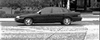

In [29]:
# show random image
i=4
Image.fromarray(test_images[i])

In [30]:
# make 1 big array again from list
test_images = np.array(test_images, dtype=floatx())

### Standardize Test Set

The test data has to be standardized <b>in the same way</b> as the training data for compatibility with the model! That means, we take the mean and standard deviation of the <i>training data</i> to transform also the test data.

In [31]:
# NO! we take the same mean and stddev from the training data above!
#mean = test_images.mean()
#stddev = test_images.std()
#print(mean, stddev)

In [32]:
test_images.mean(), test_images.std()

(122.19741, 72.07708)

In [33]:
# re-use values from train set above
test_images = (test_images - mean) / stddev

### Flatten Images for Full model

In [34]:
test_images_flat = test_images.reshape(test_images.shape[0],-1)
test_images_flat.shape

(170, 4000)

### Make Predictions

In [35]:
test_pred = model.predict_classes(test_images_flat)
# show 30 first predictions
test_pred[0:30,0]

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0], dtype=int32)

In [36]:
# Groundtruth:
# this TEST SET contains ONLY CARS on images! 
# Thus all the test classes are 1
test_classes = [1] * len(files)

In [37]:
# let's count the number of ones ...
test_pred.sum()

96

As ALL our test classes are 1, counting the number of 1's and dividing by number of files gives us the Accuracy:

In [38]:
len(files)

170

In [39]:
test_pred.sum() / len(files)

0.5647058823529412

The real way to do it is to compare the predictions (test_pred) with the ground truth (test_classes) and sum up the correct ones.
This is exactly what the scikit-learn function <i>accuracy_score</i> does:

In [40]:
acc = accuracy_score(test_classes, test_pred)
acc

0.5647058823529412

Accuracy on the Test Set is rather low.

# Convolutional Neural Networks

A Convolutional Neural Network (ConvNet or CNN) is a type of (deep) Neural Network that is well-suited for 2D axes data, such as images, as it is optimized for learning from spatial proximity. Its core elements are 2D filter kernels which essentially learn the weights of the Neural Network, and downscaling functions such as Max Pooling.

A CNN can have one or more Convolution layers, each of them having an arbitrary number of N filters (which define the depth of the CNN layer), following typically by a pooling step, which groups neighboring pixels together and thus reduces the image resolution by retaining only the maximum values of neighboring pixels.

### Input

Our input to the CNN is the standardized version of the original image array.

#### Adding the channel

For CNNs, we need to add a dimension for the color channel to the data. RGB images typically have an 3rd dimension with the color. 
<b>For greyscale images we need to add an extra dimension for compatibility with the CNN implementation.</b>

In Tensorflow, the color channel is the <b>last</b> dimension in the image shape. 

For greyscale images, we add the number 1 as the depth of the additional dimension of the input shape (for RGB color images, the number of channels is 3).

In [41]:
n_channels = 1
# Tensorflow ordering 
train_img = img_array.reshape(img_array.shape[0], img_array.shape[1], img_array.shape[2], n_channels)
test_img = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], n_channels)

In [42]:
# NOTE: 2 alternative ways to do the same:
# a) train_img = np.expand_dims(img_array, axis=3)
# b) train_img = img_array[:,:,:,np.newaxis]

In [43]:
img_array.shape

(1050, 40, 100)

In [44]:
train_img.shape

(1050, 40, 100, 1)

In [45]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of images)
    
input_shape = train_img.shape[1:]  
input_shape

(40, 100, 1)

## Create a simple CNN model

We start with a simple 2 layer Convolutional Neural Network, defined as a Keras Sequential model:

In [46]:
def simpleModel():
    model = Sequential()

    # Layer 1
    model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # reducing image resolution by half

    # Layer 2
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))  # input_shape is only needed in 1st layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # the 2D output of a Conv Layer has to be flattened before going into a Dense Layer
    model.add(Flatten()) # Note: Keras does automatic shape inference.

    # Full Layer
    #model.add(Dense(256), activation='sigmoid')

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [47]:
model = simpleModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 98, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 49, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 23, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5888)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5889      
Total params: 10,689
Trainable params: 10,689
Non-trainable params: 0
_________________________________________________________________


## Training the CNN

In [48]:
# Compiling the model
loss = 'binary_crossentropy' 
optimizer = 'sgd' 

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [49]:
# TRAINING the model
epochs = 15
history = model.fit(train_img, classes, batch_size=32, epochs=epochs)

Epoch 1/15
1050/1050 [==============================] - 1s 907us/step - loss: 0.6131 - acc: 0.6962
Epoch 2/15
1050/1050 [==============================] - 1s 657us/step - loss: 0.3985 - acc: 0.8895
Epoch 3/15
1050/1050 [==============================] - 1s 655us/step - loss: 0.2661 - acc: 0.9238
Epoch 4/15
1050/1050 [==============================] - 1s 655us/step - loss: 0.2027 - acc: 0.9419
Epoch 5/15
1050/1050 [==============================] - 1s 657us/step - loss: 0.1581 - acc: 0.9562
Epoch 6/15
1050/1050 [==============================] - 1s 664us/step - loss: 0.1277 - acc: 0.9695
Epoch 7/15
1050/1050 [==============================] - 1s 653us/step - loss: 0.1077 - acc: 0.9695
Epoch 8/15
1050/1050 [==============================] - 1s 660us/step - loss: 0.0915 - acc: 0.9771
Epoch 9/15
1050/1050 [==============================] - 1s 656us/step - loss: 0.0837 - acc: 0.9771
Epoch 10/15
1050/1050 [==============================] - 1s 656us/step - loss: 0.0711 - acc: 0.9838
Epoch 11/

<b>Again, our Accuracy rises quickly to almost 100%, with the CNN now even faster than with the Fully Connected Network.
But is our model really good at predicting unseen data?</b>

### Training with Validation Data

We split off 10 % of the training data and use it as independend validation set to verify how good we are
on an independent data (not used for training) in each epoch

In [50]:
# recreate and recompile the model (otherwise we continue learning)
model = simpleModel()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# train with showing accuracy on split off validation data
history = model.fit(train_img, classes, batch_size=32, epochs=epochs, validation_split=0.1) # portion of val. data

Train on 945 samples, validate on 105 samples
Epoch 1/15
945/945 [==============================] - 1s 1ms/step - loss: 0.6407 - acc: 0.7090 - val_loss: 0.5557 - val_acc: 0.9524
Epoch 2/15
945/945 [==============================] - 1s 692us/step - loss: 0.4902 - acc: 0.8772 - val_loss: 0.2539 - val_acc: 0.9905
Epoch 3/15
945/945 [==============================] - 1s 693us/step - loss: 0.3495 - acc: 0.8921 - val_loss: 0.1889 - val_acc: 0.9905
Epoch 4/15
945/945 [==============================] - 1s 687us/step - loss: 0.2619 - acc: 0.9217 - val_loss: 0.2839 - val_acc: 0.9429
Epoch 5/15
945/945 [==============================] - 1s 689us/step - loss: 0.2070 - acc: 0.9354 - val_loss: 0.1987 - val_acc: 0.9810
Epoch 6/15
945/945 [==============================] - 1s 689us/step - loss: 0.1647 - acc: 0.9481 - val_loss: 0.2200 - val_acc: 0.9524
Epoch 7/15
945/945 [==============================] - 1s 692us/step - loss: 0.1338 - acc: 0.9608 - val_loss: 0.1837 - val_acc: 0.9619
Epoch 8/15
945/945

The results on the split-off validation data are quite high (usually similar, but not as high as on the training data).

### Using Test Set as Validation Set

<b>Note: This usually is not recommended as during experimentation you will overfit also to the test data.</b>

We show it here only for demonstration purposes to see how (bad) the validation accuracy is on our independet test data. The recommended way is to have a separate training, validation and test set (i.e. 3 splits or separate data sets).

In [51]:
# recreate and recompile the model (otherwise we continue learning)
model = simpleModel()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# show result on Test Data while training 
# we use test data as validation data to see direct results (usually NOT RECOMMENDED due to overfitting to the problem!)
validation_data = (test_img, test_classes)

history = model.fit(train_img, classes, batch_size=32, epochs=epochs, validation_data=validation_data) 

Train on 1050 samples, validate on 170 samples
Epoch 1/15
1050/1050 [==============================] - 1s 985us/step - loss: 0.5795 - acc: 0.7390 - val_loss: 1.0119 - val_acc: 0.1176
Epoch 2/15
1050/1050 [==============================] - 1s 689us/step - loss: 0.3874 - acc: 0.9162 - val_loss: 1.2716 - val_acc: 0.1765
Epoch 3/15
1050/1050 [==============================] - 1s 693us/step - loss: 0.2606 - acc: 0.9448 - val_loss: 1.7551 - val_acc: 0.1235
Epoch 4/15
1050/1050 [==============================] - 1s 700us/step - loss: 0.1904 - acc: 0.9467 - val_loss: 2.1273 - val_acc: 0.1353
Epoch 5/15
1050/1050 [==============================] - 1s 686us/step - loss: 0.1492 - acc: 0.9571 - val_loss: 2.5901 - val_acc: 0.1176
Epoch 6/15
1050/1050 [==============================] - 1s 693us/step - loss: 0.1189 - acc: 0.9686 - val_loss: 3.1190 - val_acc: 0.0941
Epoch 7/15
1050/1050 [==============================] - 1s 701us/step - loss: 0.1054 - acc: 0.9724 - val_loss: 2.6684 - val_acc: 0.1412
E

<b>On the test set we perform really bad: less than 15% Accuracy!</b>

### Verifying Accuracy on Test Set

In [52]:
test_pred = model.predict_classes(test_img)
# show 35 first predictions
test_pred[0:35,0]

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0], dtype=int32)

In [53]:
np.array(test_classes[0:35])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [54]:
predictions = model.predict_classes(test_img)
accuracy_score(test_classes, predictions)

0.13529411764705881

## A more advanced CNN model

You may try to change the following to see the impact on the result:
* number of filters
* filter kernel size (e.g. 3 x 3, 5 x 5, ...)
* adding/not adding Batch Normalization
* adding/not adding ReLU Activation
* adding/not adding Max Pooling
* changing Pooling size (e.g. 1 x 2, 2 x 2, 2 x 1, or more)
* adding/changing/removing Dropout

In [55]:
def advancedModel():
    model = Sequential()

    # this applies n_filters convolution filters of size 3x3 in each of the 2 layers below
    n_filters = 16
    kernel_size = (3, 3)

    # Layer 1
    model.add(Conv2D(n_filters, kernel_size, padding='valid', input_shape=input_shape))
    # input shape: 100x100 images with 3 channels -> input_shape should be (3, 100, 100) 
    model.add(BatchNormalization())  # ON/OFF
    model.add(Activation('relu'))  # ReLu activation
    model.add(MaxPooling2D(pool_size=(2, 2))) # reducing image resolution by half
    model.add(Dropout(0.3))  # ON/OFF: random "deletion" of %-portion of units in each batch

    # Layer 2
    model.add(Conv2D(n_filters, kernel_size))  # input_shape is only needed in 1st layer
    #model.add(BatchNormalization()) # ON/OFF
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))  # ON/OFF
    model.add(Dropout(0.3))  # ON/OFF

    # Flatten
    model.add(Flatten())
    
    # Fully Connected Layer
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [56]:
model = advancedModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 38, 98, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 38, 98, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 38, 98, 16)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 19, 49, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 49, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 17, 47, 16)        2320      
_________________________________________________________________
activation_2 (Activation)    (None, 17, 47, 16)        0         
__________

## Training the CNN

In [57]:
# Compiling the model
loss = 'binary_crossentropy' 
optimizer = 'sgd' 
#optimizer = SGD(lr=0.001)  # possibility to adapt the learn rate

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [58]:
# TRAINING the model
epochs = 15
history = model.fit(train_img, classes, batch_size=32, epochs=epochs)

Epoch 1/15
1050/1050 [==============================] - 3s 3ms/step - loss: 0.4903 - acc: 0.7800
Epoch 2/15
1050/1050 [==============================] - 2s 2ms/step - loss: 0.1926 - acc: 0.9190
Epoch 3/15
1050/1050 [==============================] - 2s 2ms/step - loss: 0.1175 - acc: 0.9562
Epoch 4/15
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0928 - acc: 0.9714
Epoch 5/15
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0663 - acc: 0.9781
Epoch 6/15
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0495 - acc: 0.9819
Epoch 7/15
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0500 - acc: 0.9886
Epoch 8/15
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0314 - acc: 0.9933
Epoch 9/15
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0255 - acc: 0.9943
Epoch 10/15
1050/1050 [==============================] - 2s 2ms/step - loss: 0.0267 - acc: 0.9895
Epoch 11/15
1050/1050 [======

### Plotting the Training Curve

The `model.fit` function returns a history including the evolution of training and validation loss and accuracy. We can plot it to see a nice training curve.

In [59]:
hist = history.history
hist.keys()

dict_keys(['loss', 'acc'])

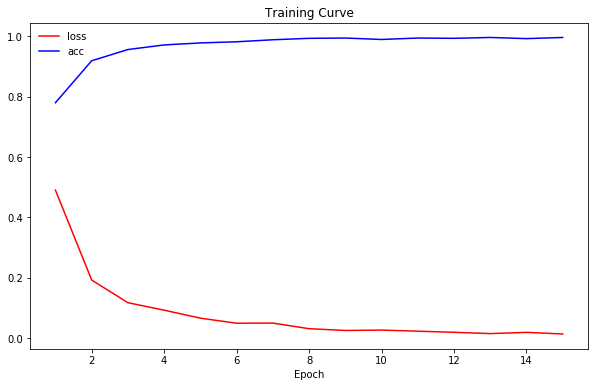

In [60]:
# this will only work if you have matplotlib installed

import matplotlib.pyplot as plt
%matplotlib inline 

colors = {'loss':'r', 'acc':'b', 'val_loss':'m', 'val_acc':'g'}
plt.figure(figsize=(10,6))
plt.title("Training Curve") 
plt.xlabel("Epoch")

for measure in hist.keys():
    color = colors[measure]
    plt.plot(range(1,epochs+1), hist[measure], color + '-', label=measure)  # use last 2 values to draw line

plt.legend(loc='upper left', scatterpoints = 1, frameon=False)


#### Conclusion: We are completely overfitting!
While we achieve nearly 100% on the Training Set, the generalization to the Test Set is really bad, with an Accuracy of about only 10%.

# Data Augmentation

Increase the training set by adding more images: Rotate, shift, flip and scale the original images to generate additional examples that will help the Neural Network to generalize better.

In [61]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [62]:
# ImageDataGenerator needs the classes as Numpy array instead of normal list
classes_array = np.array(classes)

In [63]:
np.random.seed(0) # enforce repeatable result

In [64]:
batch_size = 16
steps_per_epoch = len(train_img) / batch_size

int(steps_per_epoch)

65

In [65]:
# recreate and recompile the model (otherwise we continue learning)
model = advancedModel()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

batch_size = 32
# steps_per_epoch is the number of batches to draw from the generator at each epoch. 
# suggestion: samples_per_epoch(= full train set)/batch_size
steps_per_epoch = len(train_img) / batch_size

# fits the model on batches with real-time data augmentation:
history = model.fit_generator(datagen.flow(train_img, classes_array, batch_size=batch_size),
                    steps_per_epoch=steps_per_epoch, epochs=epochs,
                    validation_data=validation_data) 

Epoch 1/15
33/32 [==============================] - 3s 90ms/step - loss: 0.6974 - acc: 0.5845 - val_loss: 0.8406 - val_acc: 0.3824
Epoch 2/15
33/32 [==============================] - 2s 66ms/step - loss: 0.5691 - acc: 0.7002 - val_loss: 0.6691 - val_acc: 0.6118
Epoch 3/15
33/32 [==============================] - 2s 67ms/step - loss: 0.5611 - acc: 0.7186 - val_loss: 0.8905 - val_acc: 0.4353
Epoch 4/15
33/32 [==============================] - 2s 66ms/step - loss: 0.5229 - acc: 0.7510 - val_loss: 0.9012 - val_acc: 0.4706
Epoch 5/15
33/32 [==============================] - 2s 68ms/step - loss: 0.4854 - acc: 0.7703 - val_loss: 0.4493 - val_acc: 0.7647
Epoch 6/15
33/32 [==============================] - 2s 68ms/step - loss: 0.4473 - acc: 0.7859 - val_loss: 0.9905 - val_acc: 0.4235
Epoch 7/15
33/32 [==============================] - 2s 67ms/step - loss: 0.4278 - acc: 0.8072 - val_loss: 0.7630 - val_acc: 0.5824
Epoch 8/15
33/32 [==============================] - 2s 68ms/step - loss: 0.3681 - a

### Verifying Accuracy on Test Set (with Data Augmentation)

In [66]:
test_pred = model.predict_classes(test_img)
test_pred[0:35,0] # show 35 first predictions

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0], dtype=int32)

In [67]:
predictions = model.predict_classes(test_img)
accuracy_score(test_classes, predictions)

0.6882352941176471

<b>Conclusion: With Data Augmentation, the model has more diverse training examples and generalizes much better. The Accuracy on the Test Set increases from less than 10% to more than 55% up to 75%!</b>

### Plotting the Training Curve with Data Augmentation 

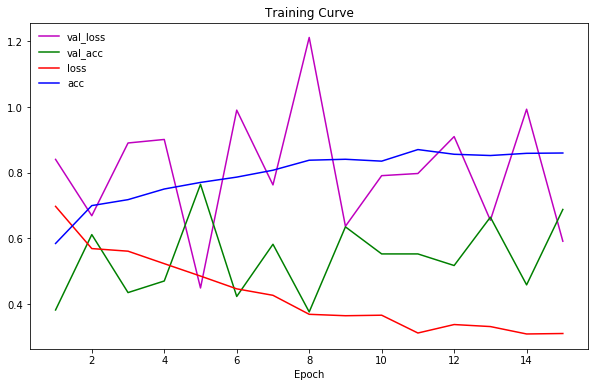

In [68]:
hist = history.history

plt.figure(figsize=(10,6))
plt.title("Training Curve") 
plt.xlabel("Epoch")

for measure in hist.keys():
    color = colors[measure]
    plt.plot(range(1,epochs+1), hist[measure], color + '-', label=measure)  # use last 2 values to draw line

plt.legend(loc='upper left', scatterpoints = 1, frameon=False)


This graph is not ideal, but we see both training (blue) and validation (green) Accuracy going up, the training loss going continuously down and the validation loss fluctuating, but not exploding like previously.

# Home Exercises 1

* **Exercise 1.1)** Adjust the parameters mentioned under "A more advanced CNN model" in the code block of "def advancedModel():" above: Tune the parameters and find a model configuration that performs better on the Test Set.
* **Exercise 1.2)** Try to improve the Data Augmentation further by adjusting the parameters of the ImageDataGenerator and/or the batch_size and/or steps_per_epoch.

For both exercises include:
* the code block with the parametrs of the model / augmentation you adapted
* the best achieved validation accuracy + valiation loss
* the plot of the training curve